In [1]:
#Jalar bibliotecas que serán de utilidad para la tarea: 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import sqldf
import scipy.stats
from scipy.special import gamma
from scipy.stats import beta
from scipy.stats import spearmanr
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

Jalamos la base de la tarea anterior:

In [2]:
base_general=(pd.read_csv("./Base_tarea1_chida.csv")).iloc[:,1:]

In [3]:
base_general.head(5)

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,1.0,26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,0.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,1.0,28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,1.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,1.0,14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,0.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,1.0,11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,0.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,1.0,11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,0.0


# MODELO LOGÍSTICO CON WOES


Jalamos otra librería que será de utilidad:

In [4]:
pip install optbinning==0.6

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pluggy<1.0,>=0.12 in c:\users\leon\anaconda3\lib\site-packages (from pytest->optbinning==0.6) (0.13.1)



In [5]:
from optbinning import OptimalBinning

Definimos una lista cuya función será la de construir, junto a otra lista llamada de nuevo, un for que permita aplicar la transformación woe a las covariables elegidas. 

In [6]:
columnas=list(base_general.columns.values)
columnas.remove("_id_")
columnas.remove("_id2_")

In [7]:
columnas

['comp_externo1',
 'comp_externo2',
 'comp_externo3',
 'comp_externo4',
 'fecha_inicio',
 'comp_interno1',
 'comp_interno2',
 'comp_interno3',
 'comp_interno4',
 'categoria1',
 'categoria2',
 'categoria3',
 'cantidad_tramites',
 'ultima_fecha',
 'avg(comportamiento_j)',
 'max(comportamiento_j)',
 'cero_meses',
 'uno_o_mas',
 'comp_mixto1',
 'inversion',
 'Respuesta']

Guardamos la respuesta en una variable

In [8]:
y=base_general.Respuesta
y.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: Respuesta, dtype: float64

Establecemos cuáles serán las variables categóricas, ya que de esto depende el tipo de transformación que se aplica para utilizar los woes.

In [9]:
categoricas=[columnas.remove("comp_interno2"),columnas.remove("categoria1"),columnas.remove("categoria2"),columnas.remove("categoria3")]
categoricas=["comp_interno2","categoria1","categoria2","categoria3"]

Nos olvidamos de las columnas de respuesta y las covariables que tienen fechas, ya que son datos complicados de trabajar

In [10]:
columnas.remove("Respuesta")
columnas.remove("fecha_inicio")
columnas.remove("ultima_fecha")

In [11]:
columnas

['comp_externo1',
 'comp_externo2',
 'comp_externo3',
 'comp_externo4',
 'comp_interno1',
 'comp_interno3',
 'comp_interno4',
 'cantidad_tramites',
 'avg(comportamiento_j)',
 'max(comportamiento_j)',
 'cero_meses',
 'uno_o_mas',
 'comp_mixto1',
 'inversion']

Hacemos el tratamiento para hacer intervalos o grupos óptimos

In [12]:
base_general.columns

Index(['_id_', 'comp_externo1', 'comp_externo2', 'comp_externo3',
       'comp_externo4', 'fecha_inicio', 'comp_interno1', 'comp_interno2',
       'comp_interno3', 'comp_interno4', 'categoria1', 'categoria2',
       'categoria3', 'cantidad_tramites', 'ultima_fecha',
       'avg(comportamiento_j)', 'max(comportamiento_j)', 'cero_meses',
       'uno_o_mas', '_id2_', 'comp_mixto1', 'inversion', 'Respuesta'],
      dtype='object')

In [13]:
opts=[] 
denuevo=list(base_general.columns.values)
denuevo.remove("_id_")
denuevo.remove("_id2_")
denuevo.remove("Respuesta")
denuevo.remove("fecha_inicio")
denuevo.remove("ultima_fecha")
for i in denuevo:
    if i in columnas:
        opts.append(OptimalBinning(name=i, dtype="numerical", solver="cp"))
    else:
        opts.append(OptimalBinning(name=i, dtype="categorical", solver="mip"))

In [14]:
opts

[OptimalBinning(name='comp_externo1'),
 OptimalBinning(name='comp_externo2'),
 OptimalBinning(name='comp_externo3'),
 OptimalBinning(name='comp_externo4'),
 OptimalBinning(name='comp_interno1'),
 OptimalBinning(dtype='categorical', name='comp_interno2', solver='mip'),
 OptimalBinning(name='comp_interno3'),
 OptimalBinning(name='comp_interno4'),
 OptimalBinning(dtype='categorical', name='categoria1', solver='mip'),
 OptimalBinning(dtype='categorical', name='categoria2', solver='mip'),
 OptimalBinning(dtype='categorical', name='categoria3', solver='mip'),
 OptimalBinning(name='cantidad_tramites'),
 OptimalBinning(name='avg(comportamiento_j)'),
 OptimalBinning(name='max(comportamiento_j)'),
 OptimalBinning(name='cero_meses'),
 OptimalBinning(name='uno_o_mas'),
 OptimalBinning(name='comp_mixto1'),
 OptimalBinning(name='inversion')]

In [61]:
for i in range(1,len(denuevo)):
    opts_B = opts[i].fit(base_general[denuevo[i]],y)

In [62]:
opts_B

OptimalBinning(name='inversion')

En el siguiente bloque, calculamos los woes asociados a cada uno de los registros de las covariables que podrían ser utilizadas

In [17]:
premade="woe_"
for i in range(len(denuevo)):
    base_general[premade+denuevo[i]]=opts[i].transform(base_general[denuevo[i]], metric="woe")

In [18]:
base_general.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,woe_categoria1,woe_categoria2,woe_categoria3,woe_cantidad_tramites,woe_avg(comportamiento_j),woe_max(comportamiento_j),woe_cero_meses,woe_uno_o_mas,woe_comp_mixto1,woe_inversion
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,1.0,26.0,67.0,...,-0.041716,0.046478,0.052546,-0.017563,2.193770,-0.515628,2.188477,1.213295,-0.037843,0.148070
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,1.0,28.0,75.0,...,0.010014,-0.028987,-0.057339,-0.017563,-1.450433,-0.515628,-1.010188,-2.502642,0.006583,0.035333
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,1.0,14.0,55.0,...,0.015982,0.031439,-0.017651,-0.017563,2.193770,-0.515628,2.188477,1.213295,0.003510,0.028440
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,1.0,11.0,55.0,...,0.015982,-0.000317,0.098109,-0.017563,1.074232,1.074232,2.118717,1.213295,-0.037843,0.035333
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,1.0,11.0,56.0,...,0.015982,0.031439,0.098109,-0.017563,2.193770,-0.515628,2.188477,1.213295,-0.011468,0.148070


In [19]:
base_woe=base_general.iloc[:,22:]
base_woe.head(10)

,Respuesta,woe_comp_externo1,woe_comp_externo2,woe_comp_externo3,woe_comp_externo4,woe_comp_interno1,woe_comp_interno2,woe_comp_interno3,woe_comp_interno4,woe_categoria1,woe_categoria2,woe_categoria3,woe_cantidad_tramites,woe_avg(comportamiento_j),woe_max(comportamiento_j),woe_cero_meses,woe_uno_o_mas,woe_comp_mixto1,woe_inversion
0,0.0,0.033506,0.024095,0.002058,-0.002571,-0.064628,-0.014029,-0.005606,-0.009232,-0.041716,0.046478,0.052546,-0.017563,2.193770,-0.515628,2.188477,1.213295,-0.037843,0.148070
1,1.0,-0.025243,0.024095,0.002058,-0.002571,-0.000031,-0.014029,-0.005606,-0.025755,0.010014,-0.028987,-0.057339,-0.017563,-1.450433,-0.515628,-1.010188,-2.502642,0.006583,0.035333
2,0.0,0.001982,-0.017438,0.083146,-0.002571,-0.000031,-0.014029,-0.001575,-0.009232,0.015982,0.031439,-0.017651,-0.017563,2.193770,-0.515628,2.188477,1.213295,0.003510,0.028440
3,0.0,-0.010531,-0.011533,0.002058,-0.002571,0.027520,-0.014029,0.094292,-0.009232,0.015982,-0.000317,0.098109,-0.017563,1.074232,1.074232,2.118717,1.213295,-0.037843,0.035333
4,0.0,-0.010531,-0.011533,-0.023450,-0.002571,0.027520,-0.014029,0.094292,-0.009232,0.015982,0.031439,0.098109,-0.017563,2.193770,-0.515628,2.188477,1.213295,-0.011468,0.148070
5,0.0,-0.025243,-0.036159,0.002058,-0.002571,0.027520,-0.014029,-0.001575,-0.009232,0.015982,0.046478,0.022677,-0.017563,2.193770,-0.515628,2.188477,1.213295,0.102773,0.098892
6,1.0,0.033506,0.082838,0.016225,-0.002571,0.027520,-0.014029,-0.001575,-0.009232,0.015982,-0.066297,-0.017651,-0.017563,-1.450433,-0.515628,-1.010188,-2.621025,-0.011468,0.035333
7,0.0,0.033506,0.024095,0.083146,-0.002571,0.027520,0.034047,-0.001575,-0.025755,0.015982,-0.000317,-0.017651,-0.017563,1.074232,1.074232,2.118717,1.213295,0.006583,0.035333
8,0.0,-0.025243,-0.036159,-0.023450,-0.002571,-0.000031,-0.014029,0.094292,-0.009232,0.015982,-0.000317,0.098109,-0.017563,1.074232,1.074232,2.118717,1.213295,-0.011468,0.028440
9,1.0,-0.010531,-0.011533,0.004096,-0.002571,0.027520,-0.014029,-0.001575,-0.009232,-0.041716,0.046478,0.022677,-0.017563,1.074232,1.074232,-1.010188,1.213295,0.006583,0.028440


Hacemos la división de los datos en train y test:

In [20]:
train,test = train_test_split(base_woe, test_size = 0.30, random_state = 100) 

In [36]:
X_woe_train=train.iloc[:,1:] 
y_train=train.Respuesta

In [37]:
X_woe_test=test.iloc[:,1:]
y_test=test.Respuesta

Los siguientes bloques de código nos ayudarán a escoger las covariables con las que vamos a trabajar por medio del _t-test_ de significancia de coeficientes, considerando un nivel $\alpha=0.05$

In [23]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_train,sm.add_constant(X_woe_train)).fit()

Optimization terminated successfully.
         Current function value: 0.305343
         Iterations 11


In [24]:
print(logitmodel.summary())

                           Logit Regression Results                           
Dep. Variable:              Respuesta   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34981
Method:                           MLE   Df Model:                           18
Date:                Thu, 06 Jan 2022   Pseudo R-squ.:                  0.4715
Time:                        11:15:53   Log-Likelihood:                -10687.
converged:                       True   LL-Null:                       -20220.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.8350      0.712     -8.194      0.000      -7.231      -4.439
woe_comp_externo1            -0.9312      0.669     -1.392      0.164      -2.243     

In [25]:
logitmodel.pvalues

const                         2.520213e-16
woe_comp_externo1             1.640608e-01
woe_comp_externo2             7.244082e-01
woe_comp_externo3             7.997405e-02
woe_comp_externo4             6.002650e-01
woe_comp_interno1             9.575199e-10
woe_comp_interno2             9.344010e-01
woe_comp_interno3             2.709413e-01
woe_comp_interno4             3.513588e-01
woe_categoria1                3.218078e-03
woe_categoria2                4.776250e-01
woe_categoria3                4.117451e-03
woe_cantidad_tramites         9.680301e-12
woe_avg(comportamiento_j)     1.670461e-09
woe_max(comportamiento_j)     1.255394e-20
woe_cero_meses               6.659401e-249
woe_uno_o_mas                 0.000000e+00
woe_comp_mixto1               6.714251e-04
woe_inversion                5.997482e-109
dtype: float64

El siguiente bloque quita todas aquellas variables cuyo _p-value_ esté por debajo de la $\alpha$ fijada. Nótese que también se quitaron algunas variables que tenían alta correlación con otras variables (esto último se visualizó en el mapa de calor de correlación que está unos cuantos bloques debajo)

In [26]:
quitar=[]
nombres=X_woe_train.columns.values
for i in range(0,len(logitmodel.pvalues)-1): 
    if logitmodel.pvalues[i+1]>=0.05:
        quitar.append(nombres[i])
quitar.append("woe_uno_o_mas")
#Por correlación alta:
quitar.append("woe_avg(comportamiento_j)")
quitar.append("woe_cantidad_tramites")
X_woe_trainf=X_woe_train.drop(columns=quitar)

In [27]:
quitar #p-value grande

['woe_comp_externo1',
 'woe_comp_externo2',
 'woe_comp_externo3',
 'woe_comp_externo4',
 'woe_comp_interno2',
 'woe_comp_interno3',
 'woe_comp_interno4',
 'woe_categoria2',
 'woe_uno_o_mas',
 'woe_avg(comportamiento_j)',
 'woe_cantidad_tramites']

In [28]:
X_woe_trainf.head()

,woe_comp_interno1,woe_categoria1,woe_categoria3,woe_max(comportamiento_j),woe_cero_meses,woe_comp_mixto1,woe_inversion
48824,0.027520,0.015982,-0.000653,2.071679,-1.010188,-0.011468,0.035333
2704,0.027520,-0.041716,-0.017651,-0.515628,2.188477,0.003510,0.035333
25631,0.027520,0.015982,0.098109,-0.515628,-1.010188,-0.011468,0.035333
7285,0.027520,0.010014,-0.000653,-0.515628,2.188477,-0.011468,0.035333
27346,-0.064628,0.010014,0.022677,-0.515628,-1.010188,0.003510,0.035333


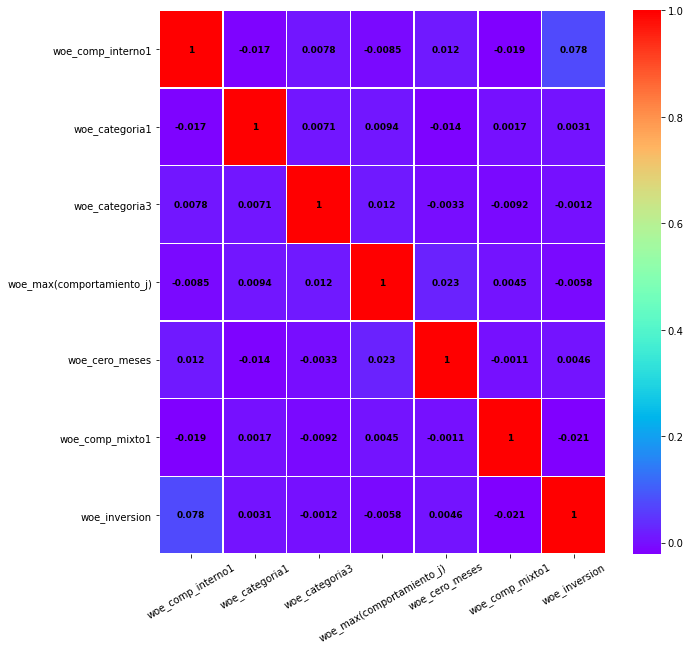

In [29]:
corr = X_woe_trainf.corr()


xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [30]:
y_trainw=y_train 

In [31]:
y_trainw.head()

48824    0.0
2704     0.0
25631    1.0
7285     0.0
27346    0.0
Name: Respuesta, dtype: float64

A continuación, entrenamos el modelo de Regresión Logística con las covariables significativas y dibujamos la curva ROC asociada a dicho modelo en el set de train.

In [32]:
model=LogisticRegression()
clf=model.fit(X_woe_trainf,y_trainw)

y_pred
 [0. 0. 1. ... 1. 1. 0.]
y_pred1
 [-2.31831984 -2.80375716  0.46973778 ...  0.4404719   0.5682112
 -1.16561807]
y_pred_p
 [[0.91038296 0.08961704]
 [0.94287852 0.05712148]
 [0.38467831 0.61532169]
 ...
 [0.39162853 0.60837147]
 [0.36164968 0.63835032]
 [0.76235205 0.23764795]]


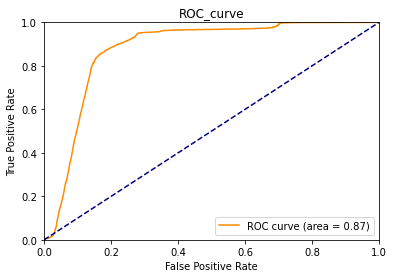

In [119]:
y_pred=clf.predict(X_woe_trainf)
y_pred1=clf.decision_function(X_woe_trainf)
y_pred_p = clf.predict_proba(X_woe_trainf)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)
print('y_pred_p\n',y_pred_p)
#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_trainw, y_pred1)
roc_auc_train = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_testf' is not defined

In [104]:
#Brian y Lalo: continuen con lo de el Kolmogorov-Smirnov y lo del Gini. Esta línea podría ser de utilidad
ks_2samp(y_train,y_pred) #PRUEBA DE DISTRIBUCIONES IGUALES 
df = y_trainw.to_frame()
df["estimado"]=y_pred_p[:,1]
df



,Respuesta,estimado
48824,0.0,0.089617
2704,0.0,0.057121
25631,1.0,0.615322
7285,0.0,0.053076
27346,0.0,0.654603
...,...,...
16304,0.0,0.045625
79,0.0,0.074665
12119,0.0,0.608371
14147,1.0,0.638350


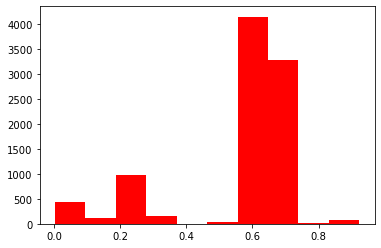

In [81]:
#Histograma de los "buenos"
hist(df[df["Respuesta"]==1.0]["estimado"],color="red")
show()

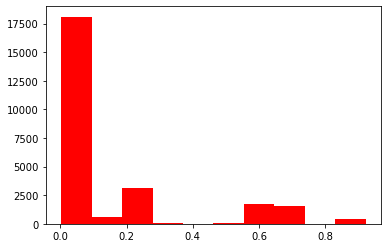

In [82]:
#Histograma de los "malos" 
hist(df[df["Respuesta"]==0.0]["estimado"],color="red")
show()

In [83]:
#Particion de intervalos
df["Rangos_prob"]=pd.qcut(df.estimado, 15)
df.head

<bound method NDFrame.head of        Respuesta  estimado       Rangos_prob
48824        0.0  0.089617  (0.0603, 0.0961]
2704         0.0  0.057121  (0.0548, 0.0603]
25631        1.0  0.615322    (0.279, 0.621]
7285         0.0  0.053076  (0.0517, 0.0548]
27346        0.0  0.654603     (0.65, 0.668]
...          ...       ...               ...
16304        0.0  0.045625  (0.0116, 0.0471]
79           0.0  0.074665  (0.0603, 0.0961]
12119        0.0  0.608371    (0.279, 0.621]
14147        1.0  0.638350     (0.621, 0.64]
38408        0.0  0.237648    (0.228, 0.279]

[35000 rows x 3 columns]>

In [85]:
df.groupby(["Respuesta","Rangos_prob"]).count()

estimado
Respuesta Rangos_prob                               
0.0       (0.0017200000000000002, 0.00954]      2332
          (0.00954, 0.0103]                     2347
          (0.0103, 0.0116]                      2313
          (0.0116, 0.0471]                      2091
          (0.0471, 0.0517]                      2301
          (0.0517, 0.0548]                      2311
          (0.0548, 0.0603]                      2316
          (0.0603, 0.0961]                      2216
          (0.0961, 0.228]                       1841
          (0.228, 0.279]                        1725
          (0.279, 0.621]                         805
          (0.621, 0.64]                          681
          (0.64, 0.65]                           647
          (0.65, 0.668]                          683
          (0.668, 0.923]                        1133
1.0       (0.0017200000000000002, 0.00954]         2
          (0.00954, 0.0103]                        2
          (0.0103, 0.0116]                         9
          (0.0116, 0.0471]                       241
          (0.0471, 0.0517]                        32
          (0.0517, 0.0548]                        21
          (0.0548, 0.0603]                        31
          (0.0603, 0.0961]                       102
          (0.0961, 0.228]                        492
          (0.228, 0.279]                         609
          (0.279, 0.621]                        1541
          (0.621, 0.64]                         1641
          (0.64, 0.65]                          1730
          (0.65, 0.668]                         1617
          (0.668, 0.923]                        1188

In [88]:
#PAQUETE
from statsmodels.distributions.empirical_distribution import ECDF


In [92]:
#KS
ecdf_malos=ECDF(df.loc[df.Respuesta == 1.0, "estimado"])
ecdf_buenos=ECDF(df.loc[df.Respuesta == 0.0, "estimado"])
grid_score=np.sort(df.estimado.unique())
prob_acum_buenos = ecdf_buenos(grid_score)
prob_acum_malos = ecdf_malos(grid_score)

In [93]:
abs_dif = np.abs(prob_acum_buenos - prob_acum_malos)
KS = np.max(abs_dif)
KS

0.6879244041178412

TypeError: 'list' object is not callable

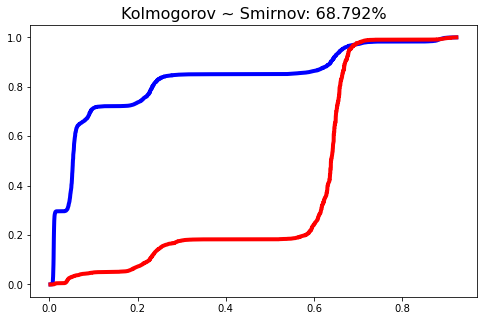

In [95]:
fig, ax =plt.subplots(figsize=(8,5))

ax.set_title(f"Kolmogorov ~ Smirnov: {KS:.3%}",fontsize=16)
plot(grid_score,prob_acum_buenos,color ="blue" , linewidth = 4)
plot(grid_score,prob_acum_malos,color ="red" , linewidth = 4)
xticks(fontsize = 16)
yticks(fontsize = 16)
show()

In [100]:
Ahora vamos a crear una tabla para observar porcentaje de buenos y malos para poder construir un ks,
con la muestra de entrenamiento.

SyntaxError: invalid syntax (<ipython-input-100-bb0e3259da7b>, line 1)

In [101]:
y_pred

array([0., 0., 1., ..., 1., 1., 0.])

Ahora calculamos la curva Roc en el set de test usando, evidentemente, las variables significativas.

In [102]:
quitar=[]
nombres=X_woe_train.columns.values
for i in range(0,len(logitmodel.pvalues)-1): 
    if logitmodel.pvalues[i+1]>=0.05:
        quitar.append(nombres[i])
quitar.append("woe_uno_o_mas")  
quitar.append("woe_avg(comportamiento_j)")
quitar.append("woe_cantidad_tramites")
X_woe_testf=X_woe_test.drop(columns=quitar)

y_pred
 [0. 0. 0. ... 0. 0. 1.]
y_pred1
 [-2.94213226 -4.56463311 -1.30123621 ... -4.60343872 -2.28292329
  0.8748023 ]
y_pred_p_test
 [[0.94989032 0.05010968]
 [0.98969363 0.01030637]
 [0.78604296 0.21395704]
 ...
 [0.99008202 0.00991798]
 [0.90745284 0.09254716]
 [0.29425603 0.70574397]]


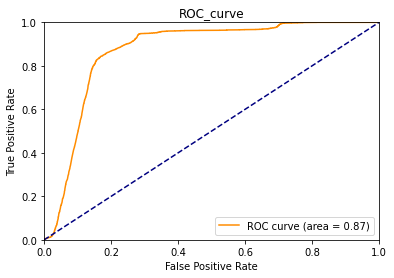

In [121]:
y_pred=clf.predict(X_woe_testf)
y_pred1=clf.decision_function(X_woe_testf)
y_pred_p_test = clf.predict_proba(X_woe_testf)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)
print('y_pred_p_test\n',y_pred_p_test)
#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_test, y_pred1)
roc_auc_test = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

Definimos una base que será de utilidad más tarde...

In [ ]:
base_woep=base_woe.drop(columns=quitar)

In [107]:
ks_2samp(y_test,y_pred)
df_test = y_test.to_frame()
df_test["estimado"]=y_pred_p_test[:,1]
df_test



,Respuesta,estimado
4253,0.0,0.050110
30076,0.0,0.010306
48047,0.0,0.213957
1666,0.0,0.056002
30740,0.0,0.055055
...,...,...
24718,1.0,0.628349
28544,1.0,0.668652
37929,0.0,0.009918
34814,0.0,0.092547


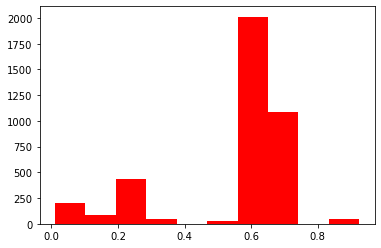

In [108]:
#Histograma de los "buenos"
hist(df_test[df_test["Respuesta"]==1.0]["estimado"],color="red")
show()

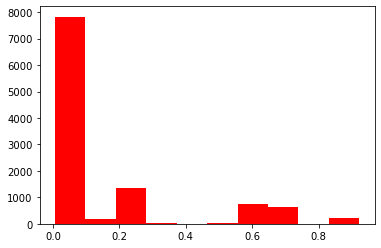

In [109]:
#Histograma de los "buenos"
hist(df_test[df_test["Respuesta"]==0.0]["estimado"],color="red")
show()

In [114]:
#Particion de intervalos
df_test["Rangos_prob"]=pd.qcut(df_test.estimado, 7) #7 intervalos para no tener intervalos donde no se asignan probabilidades
df_test.head

<bound method NDFrame.head of        Respuesta  estimado        Rangos_prob
4253         0.0  0.050110   (0.0487, 0.0561]
30076        0.0  0.010306  (0.00515, 0.0104]
48047        0.0  0.213957     (0.211, 0.609]
1666         0.0  0.056002   (0.0487, 0.0561]
30740        0.0  0.055055   (0.0487, 0.0561]
...          ...       ...                ...
24718        1.0  0.628349     (0.609, 0.649]
28544        1.0  0.668652     (0.649, 0.925]
37929        0.0  0.009918  (0.00515, 0.0104]
34814        0.0  0.092547    (0.0561, 0.211]
25776        1.0  0.705744     (0.649, 0.925]

[15000 rows x 3 columns]>

In [115]:
df_test.groupby(["Respuesta","Rangos_prob"]).count()

estimado
Respuesta Rangos_prob                
0.0       (0.00515, 0.0104]      2145
          (0.0104, 0.0487]       2011
          (0.0487, 0.0561]       2147
          (0.0561, 0.211]        1900
          (0.211, 0.609]         1386
          (0.609, 0.649]          616
          (0.649, 0.925]          844
1.0       (0.00515, 0.0104]         1
          (0.0104, 0.0487]        130
          (0.0487, 0.0561]         18
          (0.0561, 0.211]         220
          (0.211, 0.609]          756
          (0.609, 0.649]         1527
          (0.649, 0.925]         1299

In [116]:
#KS
ecdf_malos_test=ECDF(df_test.loc[df_test.Respuesta == 1.0, "estimado"])
ecdf_buenos_test=ECDF(df_test.loc[df_test.Respuesta == 0.0, "estimado"])
grid_score_test=np.sort(df_test.estimado.unique())
prob_acum_buenos_test = ecdf_buenos_test(grid_score_test)
prob_acum_malos_test = ecdf_malos_test(grid_score_test)

In [117]:
abs_dif_test = np.abs(prob_acum_buenos_test - prob_acum_malos_test)
KS_test = np.max(abs_dif_test)
KS_test

0.6746998409033604

TypeError: 'list' object is not callable

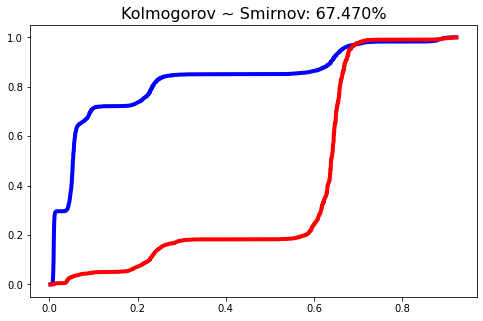

In [118]:
fig, ax =plt.subplots(figsize=(8,5))

ax.set_title(f"Kolmogorov ~ Smirnov: {KS_test:.3%}",fontsize=16)
plot(grid_score,prob_acum_buenos,color ="blue" , linewidth = 4)
plot(grid_score,prob_acum_malos,color ="red" , linewidth = 4)
xticks(fontsize = 16)
yticks(fontsize = 16)
show()

In [124]:
#GINY

giny_train = 2 * roc_auc_train - 1
giny_train
#BUEN GINY Porque es > a 60% y < a 90%

0.7501541460512688

In [123]:
giny_test = 2 * roc_auc_test - 1
giny_test
#BUEN GINY Porque es > a 60% y < a 90%

0.7391767589023095

# Árbol

La siguiente función obtiene la matriz de confusión y la curva roc de un modelo dado y para covariables y respuestas dadas

In [126]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

Importamos algunas herramientas que nos van a ser de utilidad en el ajuste de hiperparámetros

In [127]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)


Recuperamos la base que tiene todas nuestras covariables y nuevamente, como en la Regresión Logística, nos deshacemos de los id's y las fechas. 

In [128]:
newbase=base_general.iloc[:,:23]
Xa = newbase.drop(['_id_', '_id2_','fecha_inicio','ultima_fecha'], axis=1)
Xa.head()

,comp_externo1,comp_externo2,comp_externo3,comp_externo4,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3,cantidad_tramites,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,comp_mixto1,inversion,Respuesta
0,217.391304,21.545533,102.0,-230.0,3039.513678,1.0,26.0,67.0,3.0,3.0,171.0,1.0,0.083333,1.0,11.0,1.0,0.38000,52.500490,0.0
1,468.115942,21.674806,108.0,-230.0,1547.112462,1.0,28.0,75.0,1.0,11.0,173.0,1.0,0.166667,1.0,10.0,2.0,0.33360,0.047480,1.0
2,371.884058,36.857225,125.0,-230.0,1215.805471,1.0,14.0,55.0,2.0,6.0,159.0,5.0,0.083333,1.0,11.0,1.0,0.27898,227.537211,0.0
3,85.507246,6.274059,105.0,-230.0,0.000000,1.0,11.0,55.0,2.0,9.0,156.0,1.0,0.000000,0.0,12.0,0.0,0.38000,0.921995,0.0
4,72.463768,7.181844,92.0,-230.0,0.000000,1.0,11.0,56.0,2.0,6.0,156.0,1.0,0.083333,1.0,11.0,1.0,0.37050,39.259568,0.0


En los siguientes bloques, guardamos la respuesta en la variable _ya_ y dividimos a los datos en train y test, estratificando con la respuesta.

In [129]:
ya = Xa.pop('Respuesta')

In [130]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(Xa, ya,test_size=0.2,stratify=ya)

Clasificamos las variables en numéricas y en object según su tipo porque de este hecho dependen las transformaciones que le haremos a cada variable para poderlas utilizar en el modelo. Esto se hace en los siguientes bloques con ayuda de pipelines:

In [131]:
num_features = X_train_a.select_dtypes(include='number').columns.to_list()
num_features

['comp_externo1',
 'comp_externo2',
 'comp_externo3',
 'comp_externo4',
 'comp_interno1',
 'comp_interno2',
 'comp_interno3',
 'comp_interno4',
 'categoria1',
 'categoria2',
 'categoria3',
 'cantidad_tramites',
 'avg(comportamiento_j)',
 'max(comportamiento_j)',
 'cero_meses',
 'uno_o_mas',
 'comp_mixto1',
 'inversion']

In [132]:
cat_features = X_train_a.select_dtypes(include='object').columns.to_list()
cat_features

[]

In [133]:
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [134]:
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

In [135]:
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, sparse=False,
                                        handle_unknown='error', drop='first'))])

La variable _preprocessor_ guarda, precisamente, estas transformaciones que definimos anteriormente para las covariables y, algunos bloques más tarde, definimos el árbol con este preprocesador

In [136]:
preprocessor = ColumnTransformer(transformers=[
               ('numerical', num_pipeline, num_features),
               ('categorical', cat_pipeline, cat_features)],
               remainder='drop')

In [137]:
dec_tree = DecisionTreeClassifier(random_state=453)
#jugar con esto

In [138]:
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', dec_tree)])

Entrenamos el modelo: 

In [139]:
tree_pipeline.fit(X_train_a, y_train_a)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['comp_externo1',
                                                   'comp_externo2',
                                                   'comp_externo3',
                                                   'comp_externo4',
                                                   'comp_interno1',
                                                   'comp_interno2',
                                                   'comp_interno3',
                                                   'comp_interno4',
                                                   'categoria1', 'categoria2',
                                                   'categoria3',
                                  

Visualizamos el efecto del árbol en las muestras de test, con ayuda de la función definida al inicio, la cual nos muestra la matriz de confusión y la curva ROC

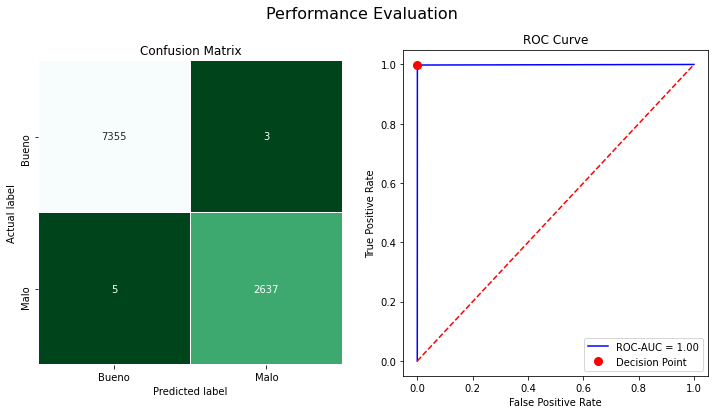

In [140]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(tree_pipeline, X_test_a,y_test_a, labels=LABELS,show_plot=True)

Como el Árbol de Decisión es un modelo inestable, vamos a quitar los datos atípicos o casos aislados de cada covariable, lo que se hace con la función que se define unos bloques adelante. Posteriormente se procede a comprobar si hubo alguna mejora en el modelo con respecto al modelo con datos atípicos; esto lo podemos ver a través de la matriz de confusión y la curva ROC:

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin

In [143]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [144]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())])

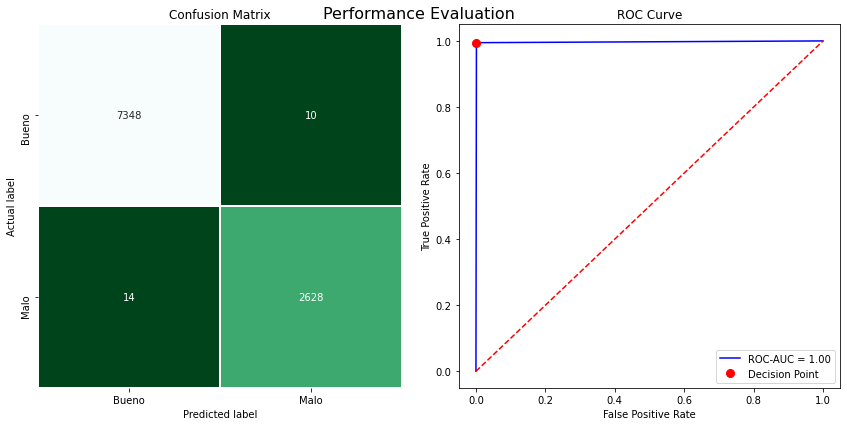

In [145]:
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],
                                 remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

tree_pipeline.fit(X_train_a, y_train_a)

tree_perf = performance_evaluation_report(tree_pipeline, X_test_a, 
                                          y_test_a, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im18.png')
plt.show()

Dado que el modelo ya era muy preciso desde el primer momento, no podemos notar gran diferencia con el modelo con datos atípicos. Sin embargo, en este caso, no hay una mejoría significativa. Lo más que se puede observar es que disminuye escasamente la frecuencia de los casos de falsos positivos o falsos negativos

A continuación, utilizaremos Cross Validation para ajustar los hiperparámetros del Árbol de Decisión, primero lo haremos con comandos de algunas librerías de Python, y luego trataremos de comprobar manualmente que la profundidad del árbol óptima que nos da la librería tenga sentido realmente. Entonces procedemos a continuación: 

In [162]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

In [163]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [164]:
cross_val_score(tree_pipeline, X_train_a, y_train_a, cv=k_fold)

array([0.9975  , 0.997125, 0.99675 , 0.997375, 0.99725 ])

In [165]:
cross_validate(tree_pipeline, X_train_a, y_train_a, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

{'fit_time': array([0.33295822, 0.38601851, 0.37661815, 0.3569839 , 0.34542322]),
 'score_time': array([0.07730937, 0.08179998, 0.12125921, 0.08042455, 0.08477688]),
 'test_accuracy': array([0.9975  , 0.997125, 0.99675 , 0.997375, 0.99725 ]),
 'test_precision': array([0.99480151, 0.99385923, 0.99431549, 0.99386213, 0.99479413]),
 'test_recall': array([0.99574267, 0.99526963, 0.99337435, 0.99621391, 0.99479413]),
 'test_roc_auc': array([0.99693691, 0.9965305 , 0.99566798, 0.99700283, 0.9964628 ])}

Le declaramos a Python cuáles son los hiperparámetros que queremos que se optimicen:

In [166]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 15),
               'classifier__min_samples_leaf': range(2, 12)}

Hacemos la optimización del modelo: 

In [167]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train_a, y_train_a)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  3.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['comp_externo1',
                                                                          'comp_externo2',
                                                                          'comp_externo3',
                                                                      

Ahora imprimimos y guardamos los mejores parámetros que escogió Python para utilizarlos más tarde, en caso de darles el visto bueno.

In [168]:
print(f'Best parameters: {classifier_gs.best_params_}')
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}')
print(f'Recall (Test set): {metrics.recall_score(y_test_a, classifier_gs.predict(X_test_a)):.4f}')

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 2}
Recall (Training set): 0.9957
Recall (Test set): 0.9962


In [169]:
clasificador=classifier_gs.best_params_['classifier__criterion']
profundidad=classifier_gs.best_params_['classifier__max_depth']
minhojas=classifier_gs.best_params_['classifier__min_samples_leaf']

Evaluamos al mejor modelo guardado en la variable _classifier$\_$gs_

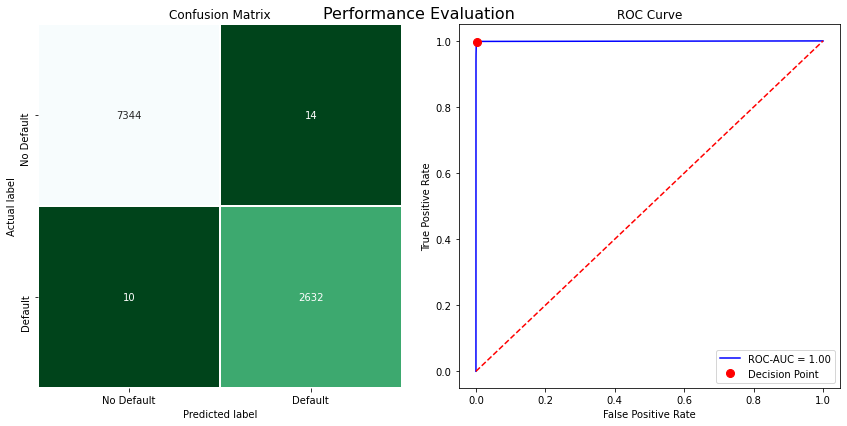

In [170]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test_a, 
                                             y_test_a, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
#plt.savefig('images/ch8_im20.png')
plt.show()

In [171]:
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score

Hacemos manualmente la comprobación de que la profundidad dada por Python sea aproximadamente la óptima:

In [189]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in range(1, 26):
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeClassifier(criterion=clasificador,
                                          max_depth=max_depth,
                                          min_samples_leaf=10,
                                          random_state=42)
    tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [],[], []
    for train_idx, test_idx in k_fold.split(X_train_a,y_train_a):
        X_t, y_t,  = X_train_a.iloc[train_idx], y_train_a.iloc[train_idx]
        X_te, y_te = X_train_a.iloc[test_idx], y_train_a.iloc[test_idx]
        arbol_fit = tree_pipeline.fit(X_t, y_t)
        train_pred = tree_pipeline.predict_proba(X=X_t)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_t)
        #print(train_score)
        train_scores[max_depth].append(train_score)

        test_pred = tree_pipeline.predict_proba(X=X_te)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_te)
        val_scores[max_depth].append(val_score)  
        #print(val_score)
        leaves[max_depth].append(max_depth)
        #reg_tree.fit(X=X_t, y=y_t)

        
        #train_scores[max_depth].append(train_score)

        #test_pred = reg_tree.predict(X=X_test)
        #val_score = np.sqrt(mean_squared_error(
        #    y_pred=test_pred, y_true=y_test))
        #val_scores[max_depth].append(val_score)
        #leaves[max_depth].append(get_leaves_count(reg_tree))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [173]:
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
bd_leaves = pd.DataFrame(leaves)

In [174]:
roc_entrenamiento=[]
for c in clf_train_scores.columns:
    promedio_roc=mean(clf_train_scores[c])
    roc_entrenamiento.append(promedio_roc)
    
roc_validacion=[]
for c in clf_valid_scores.columns:
    promedio_roc=mean(clf_valid_scores[c])
    roc_validacion.append(promedio_roc)

prof=[]
for c in bd_leaves.columns:
    id_=mean(bd_leaves[c])
    prof.append(id_)


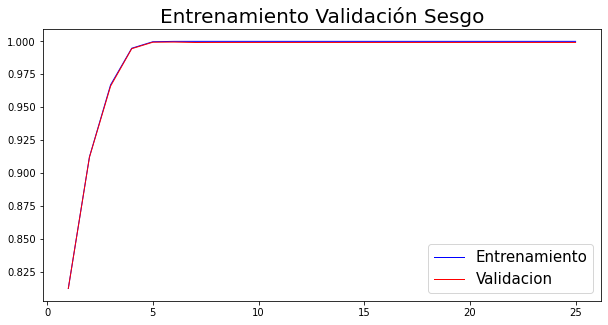

In [175]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Entrenamiento Validación Sesgo",fontsize=20)
ax.plot(prof,roc_entrenamiento,color="blue",linewidth=1,label="Entrenamiento")
ax.plot(prof,roc_validacion,color="red",linewidth=1,label="Validacion")
#gca().yaxis.set_major_formatter("{x:,.0%}")
#xticks(fontsize=16)
#yticks(fontsize=16)
#axvline(4)
legend(fontsize=15)
show()

Sin embargo, en esta situación el error del modelo en entrenamiento y validación varía muy poco respecto a la profundidad; por ende, es menester confiar en los datos arrojados por Python y por ello es que definimos un árbol con los mejores hiperparámetros según Python:

In [176]:
reg_tree = DecisionTreeClassifier(criterion=clasificador,
                                          max_depth=profundidad,
                                          min_samples_leaf=minhojas,
                                          random_state=42)
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])

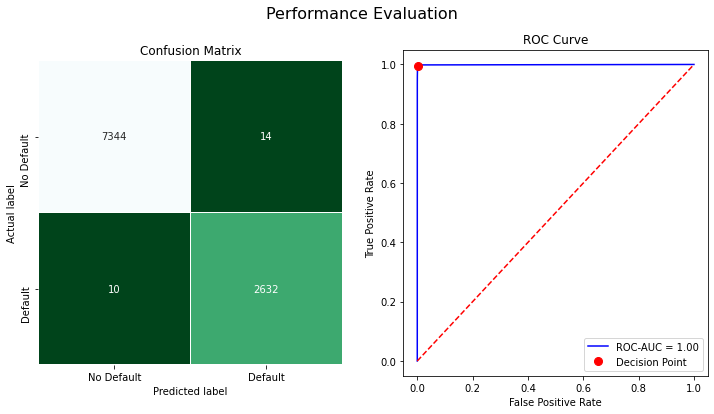

In [177]:
tree_pipeline.fit(X_train_a, y_train_a)

tree_perf = performance_evaluation_report(tree_pipeline, X_test_a, 
                                          y_test_a, labels=LABELS, 
                                          show_plot=True)

In [192]:
#KS ARBOL
#TRAIN

df_train_a = y_train_a.to_frame()
df_train_a["estimado"]=y_train_pred_a[:,1]
df_train_a




,Respuesta,estimado
9601,1.0,1.0
23024,1.0,1.0
15554,0.0,0.0
3754,0.0,0.0
4210,0.0,0.0
...,...,...
18257,0.0,0.0
14533,1.0,1.0
43573,0.0,0.0
16462,0.0,0.0


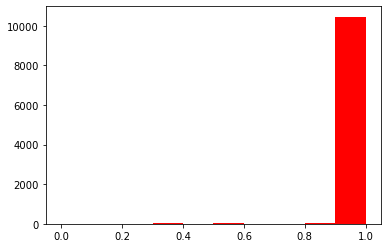

In [194]:
#Histograma de los "buenos"
hist(df_train_a[df_train_a["Respuesta"]==1.0]["estimado"],color="red")
show()

In [206]:
#Particion de intervalos
df_train_a["Rangos_prob"]=pd.qcut(df_train_a.estimado, 1)
df_train_a.head()

,Respuesta,estimado,Rangos_prob
9601,1.0,1.0,"(-0.001, 1.0]"
23024,1.0,1.0,"(-0.001, 1.0]"
15554,0.0,0.0,"(-0.001, 1.0]"
3754,0.0,0.0,"(-0.001, 1.0]"
4210,0.0,0.0,"(-0.001, 1.0]"


In [207]:
df_train_a.groupby(["Respuesta","Rangos_prob"]).count()

,,estimado
Respuesta,Rangos_prob,
0.0,"(-0.001, 1.0]",29433
1.0,"(-0.001, 1.0]",10567


In [208]:
#KS
ecdf_malos_train_a=ECDF(df_train_a.loc[df_train_a.Respuesta == 1.0, "estimado"])
ecdf_buenos_train_a=ECDF(df_train_a.loc[df_train_a.Respuesta == 0.0, "estimado"])
grid_score_train_a=np.sort(df_train_a.estimado.unique())
prob_acum_buenos_train_a = ecdf_buenos_train_a(grid_score_train_a)
prob_acum_malos_train_a = ecdf_malos_train_a(grid_score_train_a)

In [209]:
abs_dif_train_a = np.abs(prob_acum_buenos_train_a - prob_acum_malos_train_a)
KS_train_a = np.max(abs_dif_train_a)
KS_train_a

0.9960904995780138

# CROSS VALIDATION

Definimos la siguiente función para facilitar la implementación del K-Fold Cross Validation dado un modelo, las covariables, la respuesta y una lista de diferentes k's

In [ ]:
def Crossv(model,X,y,cv_list):
    for i in cv_list:
        scores=cross_val_score(model, X, y, cv=i)
        aux=scores.mean()
        print("Con {0}-fold cross validation: {1}".format(i,aux))
    return    

Primero procedemos con el árbol:

In [ ]:
tree=DecisionTreeClassifier(criterion=clasificador,
                                          max_depth=profundidad,
                                          min_samples_leaf=minhojas,
                                          random_state=42)
tree_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])

In [ ]:
Crossv(tree_pipeline2,Xa,ya,[5,10,100])

Ahora, trabajamos con la regresión:

In [ ]:
reg_cv=LogisticRegression()

In [ ]:
yw=base_woep.pop("Respuesta")

In [ ]:
Crossv(reg_cv,base_woep,yw,[5,10,100])

Nota: En la tabla mostrada a continuación, los valores del accuracy del Árbol de Decisión pueden variar con respecto a los obtenidos si se vuelve a correr todo el programa

| K-Fold | Regresión Logística | Árbol de Decisión |
| :-: | :-: | :-: |
| 5 | 0.8402800000000001 | 0.9973000000000001 |
| 10 | 0.8409800000000001 | 0.9947000000000001 |
| 100 | 0.8410400000000001 | 0.9970399999999999 |

## CONCLUSIONES

Como podemos observar, corrimos tres versiones de K-Fold Cross Validation para el modelo de Regresión Logística y lo mismo para el Árbol de Decisión, donde arbitrariamente escogimos 5,10 y 100 folds.

Los resultados de la tabla anterior son los promedios del accuracy de cada iteración del Cross Validation. De esta manera, se puede apreciar que el Árbol de Decisión se desempeñó mejor en comparación con la Regresión Logística, ya que en todos los casos, su accuracy supera al de su contrincante; concluyendo así que el __Árbol de Decisión__ es un mejor modelo para los datos trabajados. 